In [99]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using BARON
using PiecewiseLinearOpt


  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [261]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:570


Dict{String, VersionNumber} with 3 entries:
  "BARON"              => v"0.6.5"
  "PiecewiseLinearOpt" => v"0.3.0"
  "CPLEX"              => v"0.7.8"

In [91]:
innovations = CSV.File("./innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
#innovations[2,6]=7
compromise[!,3]=compromise[!,3]/2
innovations[2,2]=175
innovations[2,3]=2
innovations[1,3]=3
innovations[4,2]=168
#innovations[3,3]=2
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,3,4.6,1.34,2.04,0.12,8.86,0
2,2,175,2,8.32,8.84,0.65,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,168,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [92]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp
,Int64,Int64,Float64,Float64,Float64,Float64
1,1,1,40.0,0.6,0.5,0.0
2,2,1,43.0,0.66,0.55,0.0
3,3,1,45.5,0.68,0.567,0.0
4,4,1,47.5,0.7,0.583,0.0
5,5,2,30.0,0.4,0.0,0.2
6,6,2,32.0,0.48,0.0,0.24
7,7,2,34.0,0.5,0.0,0.27
8,8,2,38.0,0.52,0.0,0.34
9,9,2,40.0,0.54,0.0,0.37


In [93]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end

function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    
    


get_RL_DTMC (generic function with 1 method)

In [8]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp
,Int64,Int64,Float64,Float64,Float64,Float64
1,1,1,40.0,0.6,0.5,0.0
2,2,1,43.0,0.66,0.55,0.0
3,3,1,45.5,0.68,0.567,0.0
4,4,1,47.5,0.7,0.583,0.0
5,5,2,30.0,0.4,0.0,0.2
6,6,2,32.0,0.48,0.0,0.24
7,7,2,34.0,0.5,0.0,0.27
8,8,2,38.0,0.52,0.0,0.34
9,9,2,40.0,0.54,0.0,0.37


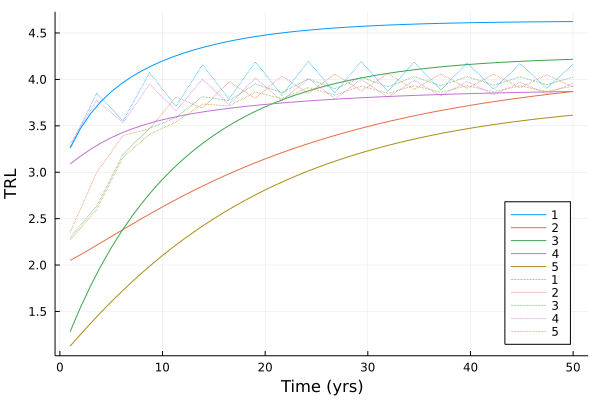

In [9]:
get_RL_atT(4,25)
pal = palette(:default)
plot([get_RL_atT.(i, 1:50) for i = 1:5]; color = [pal[i] for i = 1:5]',label=[1;2;3;4;5]')
plot_ref=plot!(range(1, 50; length = 20), [get_RL_DTMC.(i, 1:20) for i = 1:5], linestyle = :dot, color = pal[1:5]',
    labels=[1,2,3,4,5]', legend=:bottomright,ylab="TRL", xlab="Time (yrs)") 
#savefig(plot_ref,"evolution-inn_ctmc.svg")

In [10]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],sigdigits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],sigdigits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),sigdigits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

1×5 Matrix{Int64}:
 1  2  3  4  5

In [17]:
function tech_roadmap_integral()
    
    rdmap= Model(BARON.Optimizer)
    set_optimizer_attribute(rdmap, "MaxTime", 2500)
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    @variable(rdmap, s[i=1:nrow(innovations)] )
    
    @variable(rdmap, co2_2050 ≥ 0)
    @variable(rdmap, co2_tot ≥ 0)
    @variable(rdmap, 0≤ cost_inn)
    
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    @constraint(rdmap, [i=1], ti[i] ≤ sum(tk[k] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki)], ti[i] ≤ sum(tk[k] for k=mapki[i-1,2]:mapki[i,2]))
    
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3] for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    
    @variable(rdmap, eig_dec0[r=1:5,c=1,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec1[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec2[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec3[r=1,c=1:5,i=1:nrow(innovations)])
    
    @NLconstraint(rdmap,[r=1:5,i=1:nrow(innovations)],eig_dec0[r,1,i]==exp(d[r,1,i]*ti[i]))
    
    @NLconstraint(rdmap, [r=1:5,c=1:5,i=1:nrow(innovations)],eig_dec1[r,c,i]==(eig_dec0[r,1,i])*ainv[r,c,i])

    
    for r=1:5
        @NLconstraint(rdmap, [c=1:5,i=1:nrow(innovations)],eig_dec2[r,c,i]==sum(a[r,c1,i]*eig_dec1[c1,c,i] for c1 in 1:5))
    end
    
    @NLconstraint(rdmap,[c=1:5,i=1:nrow(innovations)],eig_dec3[1,c,i]==sum(s0[1,r,i]*eig_dec2[r,c,i] for r in 1:5))

    #@constraint(rdmap, sum(ti[i] for i in 1:nrow(innovations))≥ 10)
    #@NLparameter(rdmap, q[i=1:nrow(innovations)]==0)
    #@NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum([1 2 3 4 5].*((s0[:,:,i]*a[:,:,i]).*(exp.(d[:,:,i]*ti[i]))'*ainv[:,:,i])[ind] for ind in 1:5))
    @NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum(rl_vals[c]*eig_dec3[1,c,i] for c in 1:5))  
    #@constraint(rdmap, [i=1:nrow(innovations)], s[i]==s0[i])

    #@NLconstraint(rdmap,yi[2]==0)
    
    @NLconstraint(rdmap, co2_tot == 50*initial[1,3]-sum((50-tk[k])*xk[k]*(initial[1,3]-compromise[k,3]) for k in 1:nrow(compromise)))

    
    @constraint(rdmap, co2_2050 ≤ 44)
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(5-s[i])*0.968^(-1*ti[i])) for i in 1:nrow(innovations)))
    #@NLobjective(rdmap,Min, cost_inn)
    
    @variable(rdmap, obj_val ≥ 180)
    @NLconstraint(rdmap, obj_val == 40*0.001*co2_tot+cost_inn)
    @NLobjective(rdmap,Min, obj_val)
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot)
end




tech_roadmap_integral (generic function with 1 method)

In [68]:
yk, tk, xk, yi, ti, s, co2, cost1, co2tot=tech_roadmap_integral()
yi


 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             1.76     180.000          1567.65    
          1             1           

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0

In [69]:
40*0.001*co2tot

81.50244654242304

In [70]:
#2050 co2
co2

37.5

In [71]:
#time of adoption innovation
ti

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 2.600978616969219
 0.0

In [72]:
#chosen innovations
yi

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0

In [73]:
#chosen pareto points
yk

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [74]:
#fraction of functional unit
xk

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [75]:
tk

25-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 2.600978616969222
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [83]:
function tech_roadmap_mccormick()
    
    rdmap= Model(BARON.Optimizer)
    set_optimizer_attribute(rdmap, "MaxTime", 2500)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations)] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050 ≥ 0)
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0≤ cost_inn)
    
    
    #Constraints
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1], ti[i] ≤ sum(tk[k] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki)], ti[i] ≤ sum(tk[k] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3] for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #Time evolution of innovation
    #Continuous time markov chains: exponential (rate matrix times the time), eigen decomposition to convert exp(Matrix) to exp(variable)
    
    
    @variable(rdmap, eig_dec0[r=1:5,c=1,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec1[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec2[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec3[r=1,c=1:5,i=1:nrow(innovations)])
    
    @NLconstraint(rdmap,[r=1:5,i=1:nrow(innovations)],eig_dec0[r,1,i]==exp(d[r,1,i]*ti[i]))
    
    @NLconstraint(rdmap, [r=1:5,c=1:5,i=1:nrow(innovations)],eig_dec1[r,c,i]==(eig_dec0[r,1,i])*ainv[r,c,i])

    
    for r=1:5
        @NLconstraint(rdmap, [c=1:5,i=1:nrow(innovations)],eig_dec2[r,c,i]==sum(a[r,c1,i]*eig_dec1[c1,c,i] for c1 in 1:5))
    end
    
    @NLconstraint(rdmap,[c=1:5,i=1:nrow(innovations)],eig_dec3[1,c,i]==sum(s0[1,r,i]*eig_dec2[r,c,i] for r in 1:5))

    #RL state of any innovation at time of adoption ti[i] stored in s[i]
    @NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum(rl_vals[c]*eig_dec3[1,c,i] for c in 1:5))  
    
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ wk[k=1:nrow(compromise)])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≥ 50*xk[k]+tk[k]-50)
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ 50*xk[k])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ tk[k])
    
    @constraint(rdmap, co2_tot == 50*initial[1,3]-sum((50*xk[k]-wk[k])*(initial[1,3]-compromise[k,3]) for k in 1:nrow(compromise)))

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050 ≤ 44)
    
    #find present value of investment cost for objective function - time value of money x how far from adoption RL x cost per RL differential
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(5-s[i])*0.968^(-1*ti[i])) for i in 1:nrow(innovations)))
    

    #definining objective function as investment cost + Co2 emission cost during the time horizon
    @NLconstraint(rdmap, obj_val == 40*0.001*co2_tot+cost_inn)
    @NLobjective(rdmap,Min, obj_val)
    
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot)
end




tech_roadmap_mccormick (generic function with 1 method)

In [152]:
inn_reg = CSV.File("./inn_reg.csv",header=1,delim=",") |> DataFrame
inn_xrang = CSV.File("./inn_xrang.csv",header=1,delim=",") |> DataFrame


,Column1,Inn,R1,R2,R3,R4,R5
,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,1,1,2.5,10.0,22.5,37.5,50.0
2,2,2,2.5,20.0,30.0,40.0,50.0
3,3,3,5.0,15.0,25.0,37.5,50.0
4,4,4,7.5,17.5,30.0,40.0,50.0
5,5,5,12.5,22.5,32.5,42.5,50.0


In [222]:
pw_fit(1,2)

1.6493696338703994

In [209]:
function tech_roadmap_mccormick_peicewise()
    
    rdmap= Model(BARON.Optimizer)
    set_optimizer_attribute(rdmap, "MaxTime", 2500)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations)] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050 ≥ 0)
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0≤ cost_inn)
    
    
    #Constraints
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1], ti[i] ≤ sum(tk[k] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki)], ti[i] ≤ sum(tk[k] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3] for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #Time evolution of innovation
    #Continuous time markov chains: exponential (rate matrix times the time), eigen decomposition to convert exp(Matrix) to exp(variable)
    
    
    @variable(rdmap, eig_dec0[r=1:5,c=1,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec1[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec2[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec3[r=1,c=1:5,i=1:nrow(innovations)])
    
    @NLconstraint(rdmap,[r=1:5,i=1:nrow(innovations)],eig_dec0[r,1,i]==exp(d[r,1,i]*ti[i]))
    
    @NLconstraint(rdmap, [r=1:5,c=1:5,i=1:nrow(innovations)],eig_dec1[r,c,i]==(eig_dec0[r,1,i])*ainv[r,c,i])

    
    for r=1:5
        @NLconstraint(rdmap, [c=1:5,i=1:nrow(innovations)],eig_dec2[r,c,i]==sum(a[r,c1,i]*eig_dec1[c1,c,i] for c1 in 1:5))
    end
    
    @NLconstraint(rdmap,[c=1:5,i=1:nrow(innovations)],eig_dec3[1,c,i]==sum(s0[1,r,i]*eig_dec2[r,c,i] for r in 1:5))

    #RL state of any innovation at time of adoption ti[i] stored in s[i]
    @NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum(rl_vals[c]*eig_dec3[1,c,i] for c in 1:5))  
    
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ wk[k=1:nrow(compromise)])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≥ 50*xk[k]+tk[k]-50)
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ 50*xk[k])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ tk[k])
    
    @constraint(rdmap, co2_tot == 50*initial[1,3]-sum((50*xk[k]-wk[k])*(initial[1,3]-compromise[k,3]) for k in 1:nrow(compromise)))

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050 ≤ 65)
    
    #find present value of investment cost for objective function - time value of money x how far from adoption RL x cost per RL differential
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(5-s[i])*0.968^(-1*ti[i])) for i in 1:nrow(innovations)))
    @variable(rdmap,state_time[i=1:nrow(innovations)])
    for i in 1:nrow(innovations)
        state_time[i]=piecewiselinear(rdmap,ti[i],tval[:,i],fval[:,i])
        #state_time[i]=piecewiselinear(rdmap,ti[i],0:0.1:50, ti[i] -> (5-s[i])*0.968^(-1*ti[i]))
    end
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*state_time[i]) for i in 1:nrow(innovations)))
    
    @constraint(rdmap, sum(ti[i] for i in 1:nrow(innovations)) ≤ 31)

    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    @NLobjective(rdmap,Min, 40*0.001*co2_tot+cost_inn)
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot),JuMP.value.(state_time)
end




tech_roadmap_mccormick_peicewise (generic function with 1 method)

In [250]:
function piecewise_fitted_parameters(i,t)
    if(t <= inn_xrang[i,3])
        return inn_reg[i,3],inn_reg[i,4]
    elseif(inn_xrang[i,3]< t <= inn_xrang[i,4])
        return inn_reg[i,5],inn_reg[i,6]
    elseif(inn_xrang[i,4]< t <= inn_xrang[i,5])
        return inn_reg[i,7],inn_reg[i,8]
    elseif(inn_xrang[i,5]< t <= inn_xrang[i,6])
        return inn_reg[i,9],inn_reg[i,10]
    else
        return inn_reg[i,11],inn_reg[i,12]
    end
end

function pw_fit(i,t)
    if(t <= inn_xrang[i,3])
        return inn_reg[i,3]+inn_reg[i,4]*t
    elseif(inn_xrang[i,3]< t <= inn_xrang[i,4])
        return inn_reg[i,5]+inn_reg[i,6]*t
    elseif(inn_xrang[i,4]< t <= inn_xrang[i,5])
        return inn_reg[i,7]+inn_reg[i,8]*t
    elseif(inn_xrang[i,5]< t <= inn_xrang[i,6])
        return inn_reg[i,9]+inn_reg[i,10]*t
    else
        return inn_reg[i,11]+inn_reg[i,12]*t
    end
end

function pw_fit_diff(i,t)
    if(t <= inn_xrang[i,3])
        return inn_reg[i,4]
    elseif(inn_xrang[i,3]< t <= inn_xrang[i,4])
        return inn_reg[i,6]
    elseif(inn_xrang[i,4]< t <= inn_xrang[i,5])
        return inn_reg[i,8]
    elseif(inn_xrang[i,5]< t <= inn_xrang[i,6])
        return inn_reg[i,10]
    else
        return inn_reg[i,12]
    end
end


pw_fit_diff (generic function with 1 method)

In [257]:
function tech_roadmap_mccormick_peicewise_self()
    
    rdmap= Model(BARON.Optimizer)
    set_optimizer_attribute(rdmap, "MaxTime", 2500)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations)] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050 ≥ 0)
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0≤ cost_inn)
    
    
    #Constraints
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1], ti[i] ≤ sum(tk[k] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki)], ti[i] ≤ sum(tk[k] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3] for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #Time evolution of innovation
    #Continuous time markov chains: exponential (rate matrix times the time), eigen decomposition to convert exp(Matrix) to exp(variable)
    
    
    @variable(rdmap, eig_dec0[r=1:5,c=1,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec1[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec2[r=1:5,c=1:5,i=1:nrow(innovations)])
    @variable(rdmap, eig_dec3[r=1,c=1:5,i=1:nrow(innovations)])
    
    @NLconstraint(rdmap,[r=1:5,i=1:nrow(innovations)],eig_dec0[r,1,i]==exp(d[r,1,i]*ti[i]))
    
    @NLconstraint(rdmap, [r=1:5,c=1:5,i=1:nrow(innovations)],eig_dec1[r,c,i]==(eig_dec0[r,1,i])*ainv[r,c,i])

    
    for r=1:5
        @NLconstraint(rdmap, [c=1:5,i=1:nrow(innovations)],eig_dec2[r,c,i]==sum(a[r,c1,i]*eig_dec1[c1,c,i] for c1 in 1:5))
    end
    
    @NLconstraint(rdmap,[c=1:5,i=1:nrow(innovations)],eig_dec3[1,c,i]==sum(s0[1,r,i]*eig_dec2[r,c,i] for r in 1:5))

    #RL state of any innovation at time of adoption ti[i] stored in s[i]
    @NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum(rl_vals[c]*eig_dec3[1,c,i] for c in 1:5))  
    
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ wk[k=1:nrow(compromise)])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≥ 50*xk[k]+tk[k]-50)
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ 50*xk[k])
    @constraint(rdmap,[k=1:nrow(compromise)],wk[k] ≤ tk[k])
    
    @constraint(rdmap, co2_tot == 50*initial[1,3]-sum((50*xk[k]-wk[k])*(initial[1,3]-compromise[k,3]) for k in 1:nrow(compromise)))

    #setting target for 2050 co2 pledge
    #@constraint(rdmap, co2_2050 ≤ 44)
    
    #find present value of investment cost for objective function - time value of money x how far from adoption RL x cost per RL differential
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(5-s[i])*0.968^(-1*ti[i])) for i in 1:nrow(innovations)))
    @variable(rdmap,state_time[i=1:nrow(innovations)])
    for i in 1:nrow(innovations)
        state_time[i]=piecewiselinear(rdmap,ti[i],tval[:,i],fval[:,i])
        #state_time[i]=piecewiselinear(rdmap,ti[i],0:0.1:50, ti[i] -> (5-s[i])*0.968^(-1*ti[i]))
    end
    #register(rdmap, :pw_fit, 2, pw_fit, pw_fit_diff)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*pw_fit(i,ti[i])) for i in 1:nrow(innovations)))
    
    
    
    @variable(rdmap,pw[i=1:nrow(innovations),p=1:nrow(inn_reg)],Bin)
    @constraint(rdmap,[i=1:nrow(innovations)],pw[i,1]*inn_xrang[i,3] ≤ ti[i])
    @constraint(rdmap,[i=1:nrow(innovations)],pw[i,1]*inn_xrang[i,3] ≤ ti[i])
    
    
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(pw[1]*inn_reg)) for i in 1:nrow(innovations)))
    
    
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    #@constraint(rdmap, sum(ti[i] for i in 1:nrow(innovations)) ≤ 31)

    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    @NLobjective(rdmap,Min, 40*0.001*co2_tot+cost_inn)
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot)
end




tech_roadmap_mccormick_peicewise_self (generic function with 1 method)

In [256]:
yk, tk, xk, yi, ti, s, co2, cost1, co2tot=tech_roadmap_mccormick_peicewise_self()
yi


LoadError: UnrecognizedExpressionException: unrecognized function call expression: pw_fit(1.0, x[81])

In [214]:
co2

99.99999999777364

In [139]:
s_t

5-element Vector{Float64}:
 1.9930401843780352
 2.9876957501999435
 4.038422362696626
 1.9782947161585005
 3.997615177433624

In [140]:
ti

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [141]:
co2tot*40*0.001

200.0

In [51]:
yi

5-element Vector{Float64}:
 1.0
 0.0
 1.0
 0.0
 0.0

In [52]:
tk

25-element Vector{Float64}:
  0.0
 40.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
 40.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [53]:
xk


25-element Vector{Float64}:
 0.0
 0.7142857142857166
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.2857142857142833
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [54]:
yk

25-element Vector{Float64}:
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [55]:
s

5-element Vector{Float64}:
 4.613018678214271
 2.012304249800057
 4.1608142838868565
 3.0217052838415013
 1.002384822566376

In [63]:
-1*(s_t/(0.968^(-1*40)).-5)

5-element Vector{Float64}:
 4.613018678214274
 4.1865129164135615
 4.160814283886857
 4.4613517125983995
 3.911532972601467

## Additional functions

In [94]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],sigdigits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],sigdigits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),sigdigits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

function get_latest(i,t)
    e0=zeros(5,1,i)
    e1=zeros(5,5,i)
    e2=zeros(5,5,i)
    e3=zeros(1,5,i)
    for r in 1:5
        e0[r,1,i]=exp(d[r,1,i]*t)
    end

    for r in 1:5
        for c in 1:5
            e1[r,c,i]=e0[r,1,i]*ainv[r,c,i]
        end
    end

    for r in 1:5
        for c in 1:5
            e2[r,c,i]=sum(a[r,c1,i]*e1[c1,c,i] for c1 in 1:5)
        end
    end

    for c in 1:5
        e3[1,c,i]=sum(s0[1,r,i]*e2[r,c,i] for r in 1:5)
    end


    e4=sum(rl_vals[c]*e3[1,c,i] for c in 1:5)

    #rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'
    return 5-e4
end

get_latest(1,50)
#rl_vals*([0 1 0 0 0]*a[:,:,1]*Diagonal(round.(exp.(get_new2(1,t)),sigdigits=3))*get_new3(1,t))'

0.3742059960635462

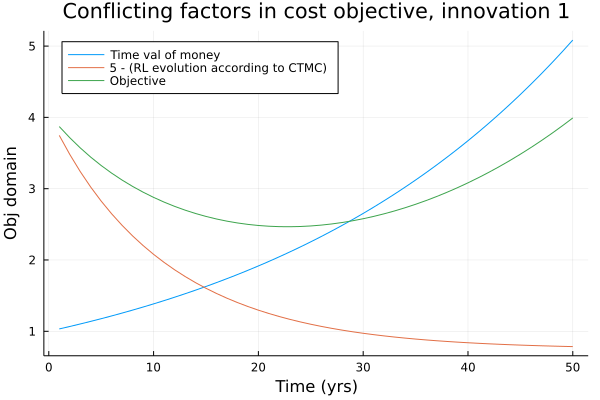

In [95]:
inn=3
plot(range(1, 50; length = 50),[0.968^(-1*i) for i = 1:50],labels="Time val of money")
plot!(range(1, 50; length = 50), [get_latest.(inn,1:50)],labels="5 - (RL evolution according to CTMC)")
plot_ref=plot!(range(1, 50; length = 50), [0.968^(-1*i)*get_latest.(inn,i) for i = 1:50], labels="Objective",legend=:topleft,
        xlab="Time (yrs)", ylab="Obj domain", title="Conflicting factors in cost objective, innovation 1")
#savefig(plot_ref,"evolution-inn_costObj.svg")

In [96]:
intvls=5
fval=zeros(intvls+1,5)
tval=zeros(intvls+1,5)
for inn in 1:5
    tval[:,inn]=[i*(50/intvls) for i = 0:intvls]
    fval[:,inn]=[0.968^(-1*i*(50/intvls))*get_latest.(inn,i*(50/intvls)) for i =0:intvls]
end
[tval[:,1] fval]

6×6 Matrix{Float64}:
  0.0  1.99304   2.9877   4.03842  1.97829  3.99762
 10.0  1.10731   3.28907  2.87796  1.98531  4.00977
 20.0  0.998003  3.56699  2.48386  2.43328  4.19855
 30.0  1.12066   4.0127   2.5786   3.16822  4.69613
 40.0  1.42127   4.71566  3.08208  4.23497  5.60362
 50.0  1.90258   5.77142  3.99192  5.74624  7.04349

In [241]:
CSV.write("cost_inn_obj.csv",  Tables.table([tval[:,1] fval]), writeheader=true)


"cost_inn_obj.csv"

In [229]:
tval

21×5 Matrix{Float64}:
  0.0   0.0   0.0   0.0   0.0
  2.5   2.5   2.5   2.5   2.5
  5.0   5.0   5.0   5.0   5.0
  7.5   7.5   7.5   7.5   7.5
 10.0  10.0  10.0  10.0  10.0
 12.5  12.5  12.5  12.5  12.5
 15.0  15.0  15.0  15.0  15.0
 17.5  17.5  17.5  17.5  17.5
 20.0  20.0  20.0  20.0  20.0
 22.5  22.5  22.5  22.5  22.5
 25.0  25.0  25.0  25.0  25.0
 27.5  27.5  27.5  27.5  27.5
 30.0  30.0  30.0  30.0  30.0
 32.5  32.5  32.5  32.5  32.5
 35.0  35.0  35.0  35.0  35.0
 37.5  37.5  37.5  37.5  37.5
 40.0  40.0  40.0  40.0  40.0
 42.5  42.5  42.5  42.5  42.5
 45.0  45.0  45.0  45.0  45.0
 47.5  47.5  47.5  47.5  47.5
 50.0  50.0  50.0  50.0  50.0

In [34]:
function get_new1(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    t1=(s0)*eigvecs(q)
    return t1
end
function get_new2(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    
    temp1=(eigvals(q))*t
    return temp1
end

function get_new3(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return inv(eigvecs(q_mat))
end


function get_new(i,t)
    return ([1 2 3 4 5]*(get_new1(i,t).*round.(exp.(get_new2(i,t)),sigdigits=3)'*get_new3(i,t))')
end
#get_RL(1,50)



i=1
t=50
s0=[0 0 0 0 0]
s0[rl[i]]=1
p_mat=reshape(collect(innovations[i,9:33]),5,5)'
q_mat=p_mat./collect(innovations[i,4:8])
for i in 1:5
    q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
end
q=q_mat
#rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
#rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
temp1=Diagonal(eigvals(q))*t
temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
d=eigvecs(q)*(temp2)*inv(eigvecs(q))
rl_t=sum([1 2 3 4 5].*(s0*d))
temp2

[exp(get_new2(4,50)[i]) for i in 1:5]
get_new1(4,50).*[exp(get_new2(4,50)[i]) for i in 1:5]
get_new2(4,50)[1]
get_new(4,50)

1×1 Matrix{Float64}:
 3.8698053730585023

In [35]:
g=exp(get_rate_mat(2)*50)


5×5 Matrix{Float64}:
 0.0815477  0.1365     0.0131513   0.447524  0.321277
 0.0712625  0.120257   0.0124373   0.459736  0.336307
 0.0461925  0.0796249  0.0106524   0.489744  0.373786
 0.0323738  0.0573037  0.00967175  0.506267  0.394383
 0.0299688  0.0534099  0.00949941  0.509059  0.398063

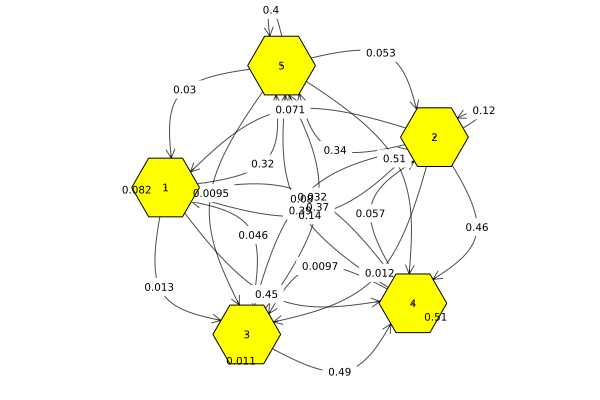

In [28]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)